# Limited band interpolation for daily reference rates
By [Juan M. Fonseca-Solís](https://juanfonsecasolis.github.io/), Mar 2015
- - -
## Summary

In this _ipython notebook_ we'll use data from daily reference rates, such as the London interbank interest rate (LIBOR) or the dollar exchange rate in Costa Rica offered monthly by the Central Bank of Costa Rica (BCCR), to explain linear and band-limited interpolation techniques.

# History

In June 2012, when resolving a legal dispute, the Commodity Futures Negotiation Commission of the United States (CFTC) discovered a series of irregularities in the management of the LIBOR by the British multinational bank Barclays. The Financial Times newspaper later confirmed the manipulation of this rate since 1991, which caused an international scandal, since the LIBOR is used as a reference to determine the interest rate of the loans in foreign currency all over the world [4,5].

![](img/libor-scandal-headlines-the-financial-times-newspaper-london-august-CTX670.jpg)

As a result, millionaire fines were imposed on the British bank and an investigation was performed to find more reliable interest rates, including the first-rate, a rate managed by US banks that is based on real transactions and not on opinion polls like the LIBOR. Because 2021 was proposed as the deadline to definitely substitute the LIBOR, and because Brexit is comming to an end, this topic has become of interest again [4,5].

![](img/article-2172377-140736A7000005DC-647_634x422.jpg)

The LIBOR, along with other daily reference rates, is published once a day with a few bunch of maturity levels (the time until the loan will be charged):
* 1 month
* 3 months
* 6 months
* 12 months

Because only 4 values are published, banks usually require to linearly interpolate other maturity levels. For example, if interest rates of 1 and 3 months LIBOR are $4.3313$% and $4.3944$%, respectively, the maturity level at $1.5$ months is $4.3155\%$, calculated as follows [6]:

$$
y_n = \frac{y_1-y_0}{x_1-x_0} (x_n-x_0) + y_0,
$$

where $(x_0,y_0)=(30$ days$, 4.3313\%)$, and $(x_1,y_1)=(90$ days$, 4.3944\%)$.

## Sampling of a signal

Even they are not continuous, LIBOR daily rates constitute a discrete signal, that mathematically, can be expressed by choosing a sampling period $T$ of 1 day and evaluating the continuous "imaginary" function as follows [2,3]:
$$
\tilde{z}[i] = z(iT) \quad i \in \mathbb{Z},
$$

where $\tilde{z}[i]$ is the discrete signal and $z(t)$ is the continuous signal. This means that the continuous signal can be converted into a discrete signal by reading its values in the instants $iT$. Using a notation of ordered pairs this can also be expressed as follows:

$$
\{(x_i,\tilde{z}_i)\}_{i=-\infty}^{\infty},
$$

where $x_{i+1}-x_i = T$ seconds. In both cases it is necessary to ensure that the $T_{\max} \ge 2T$ relationship is fulfilled (where $T_\max$ is the largest component of the signal). This relationship is summarized in what is known as the [Nyquist theorem](https://en.wikipedia.org/wiki/Nyquist%E2%80%93Shannon_sampling_theorem), if this theorem is not respected [aliasing](https://en.wikipedia.org/wiki/Aliasing) might corrupt the reconstructed signal. 

**Note:** although the Nyquist theorem is an important topic on audio and video processing applications, we will ignore it here for practical purposes and because we know that the daily rate signal is bandlimited (i.e. there are no variations between days).

## Lineal interpolation

The interpolation of a discrete signal is achieved by [convolving](https://en.wikipedia.org/wiki/Convolution) an interpolation function $I(t)$ &ndash;also called interpolation kernel&ndash; with each sample available, then a sum of all convolutions is performed to obtain a continuous function [3]: 

$$
    z(t) =  \sum_{i=-\infty}^{\infty}{\tilde{z}[i]I\big(\frac{t-iT}{T}\big)} 
$$

This is easier to understand with an example:

Populating the interactive namespace from numpy and matplotlib


<StemContainer object of 3 artists>

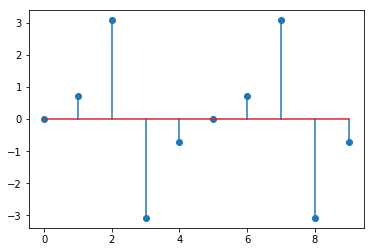

In [4]:
%pylab inline
import numpy as np
N=10
zt=np.tan(2*np.pi*10/100*np.arange(0,N))
pylab.stem(zt)

First, the previous signal is resampled at a higher sampling rate by adding zeros in the middle of the samples:

<StemContainer object of 3 artists>

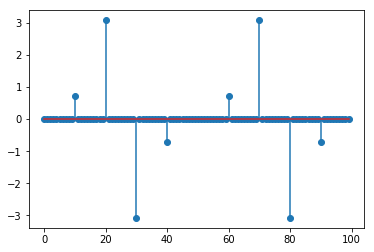

In [6]:
from scipy import signal
M=N*10
ztt = [0.0]*M
ztt[::N] = zt
pylab.stem(ztt)

Then the convolution of each sample with a triangular kernel is carried out:

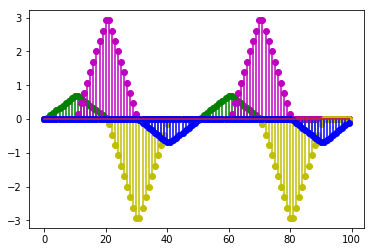

In [9]:
kernel=signal.triang(2*N)
z = np.zeros(M)
colors = ['r', 'g', 'm', 'y', 'b']
for i in range(1,N):
    zeros = np.zeros(M)
    zeros[i*N]=zt[i] 
    z += np.convolve(zeros,kernel,'same')
    pylab.stem(np.convolve(zeros,kernel,'same'),colors[i%len(colors)],markerfmt='%so'%colors[i%len(colors)])

Finally all the convolutions are added to "connect" the points:

<StemContainer object of 3 artists>

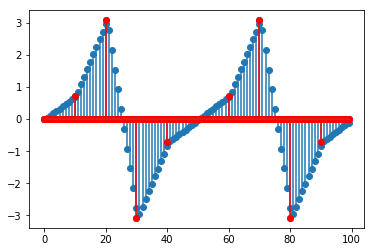

In [22]:
pylab.stem(z)
pylab.stem(ztt,'ro-')

Using a non-triangular kernel a smoother approximation can be obtained:

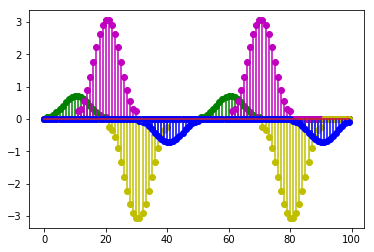

In [10]:
kernel=signal.hamming(2*N)
z = np.zeros(M)
colors = ['r', 'g', 'm', 'y', 'b']
for i in range(1,N):
    zeros = np.zeros(M)
    zeros[i*N]=zt[i] 
    z += np.convolve(zeros,kernel,'same')
    pylab.stem(np.convolve(zeros,kernel,'same'),colors[i%len(colors)],markerfmt='%so'%colors[i%len(colors)])

<StemContainer object of 3 artists>

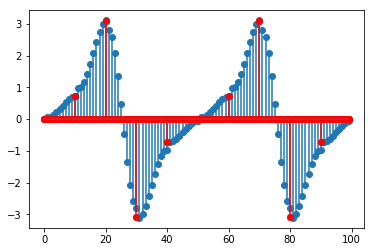

In [24]:
pylab.stem(z)
pylab.stem(ztt,'ro-')

Now, if we randomly sample the previous signal and apply the same method, we see that the reconstruction is not good, indicating that we need to use another approach when there is scattered data:

<StemContainer object of 3 artists>

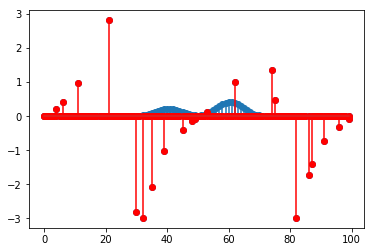

In [30]:
wtt = np.copy(z)
for m in range(0,M):
        if random.random()<0.8:
                wtt[m]=0
w = np.zeros(M)
for i in range(1,N):
    zeros = np.zeros(M)
    zeros[i*N]=wtt[i] 
    w += np.convolve(zeros,kernel,'same')
pylab.stem(w)
pylab.stem(wtt,'ro-')

Interpolation could be done even ignoring the sampling rate, but it is observed that the periodicity of the approximate function has been lost.

<StemContainer object of 3 artists>

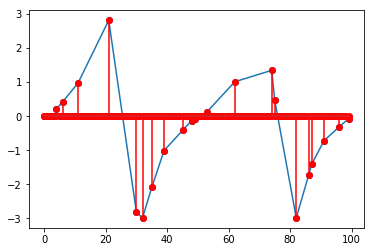

In [31]:
indexes = np.where(wtt != 0)
n = np.arange(0,len(wtt))
pylab.plot(n[indexes], wtt[indexes])
pylab.stem(wtt,'ro-')

## Bandlimited interpolation

As noted above, the interpolation problem becomes more complex when we desire to reconstruct the signal from samples taken randomly, that is, without a fixed sampling rate.<sup>1</sup> In this case, if the high frequencies are negligible, the limited band interpolation method (BLI) can be used to obtain a reasonable approximation. For this, the assumption is made that the discrete signal is [linear and invariant in time](https://en.wikipedia.org/wiki/Linear_time-invariant_system), if so, it can be modeled as a linear system, it is that is, as the multiplication between a transformation matrix and a coefficient vector, as follows [2]:

$$
Fc=z,\qquad (1)
$$

where $\{F\}_{ik} = e^{j2 \pi \frac{x_ik}{T}}$ is the $k$-th entry of the $i$-th orthogonal vector of the Fourier series and $c=(c-M, \ldots, c_M)^t $ is the vector obtained by applying the Fourier transform. Assuming that the number of linearly independent rows and columns of $F$ is the same (that is, $N = 2M + 1$), it is possible to solve the system by finding the inverse of the matrix, as follows:

$$
c=F^{-1}z.
$$

However, in real life, this rarely happens because the amount of signal samples is usually greater than the number of coefficients chosen for modeling ($2M+1<N$). Fortunately, there is an approximation using the least-squares method [2,7]:<sup>2</sup>

$$
\hat{c}=(F^t F)^{-1}F^tz.
$$

This approach becomes interpolation when we do a linear resampling of the temporary support $x_i$ in the interval $[0, T]$. For this we can use a simple rule of three:

$$
\tilde{x}_i=i\frac{T}{L}.
$$

Finally, $x_i$ is replaced by the $\tilde{x}_i$ in equation 1, and the resulting system is summarized in the following expression [2]:

$$
\tilde{z}_i=\tilde{F}\hat{c}.
$$

**Note:** a better explanation of the BLI theory can be found in the referenced ipython notebook _Safecast : Band-limited interpolation of radiation measurements in Fukushima_, make sure to check it out.

## BCCR web service consumption

Now we are going to practice with an example of another daily rate, called the dollar exchange rate for Costa Rican colones. To get the date we consume the SOAP web service of the BCCR available on the site `https://gee.bccr.fi.cr/Indicators/Subscriptions/WS/wsindicadoreseconomicos.asmx`. We start by importing the packages from the [Zolera Soap Infrastructure](http://pywebsvcs.sourceforge.net/zsi.html) library, among other utilities.

**Note:** As a prerequisite, it is necessary to install the Zolera library using the Ubuntu instruction: `sudo apt-get install python-zsi`.

In [1]:
import xml.etree.ElementTree as ET  # librería para leer el xml
from ZSI.ServiceProxy import ServiceProxy  # libería para consumir el servicio SOAP
import datetime
import numpy

The operation that offers the daily exchange rate is called "ObtenerIndicadoresEconomicosXML" and, according to the _web service description language_ (WSDL) of the BCCR, receives five parameters:
* **Indicator ID** (317, for the purchase exchange rate) [1]
* **Initial date** (in dd/mm/YYYY format)
* **End date** (same as above)
* **User name** (irrelevant, as it does not affect the operation)
* **Char Y/N** (communicate if you want to obtain a detailed report with sub-indicators)

The result of the operation is an XML with the form:

    <string><Datos_de_INGC011_CAT_INDICADORECONOMIC>
      <INGC011_CAT_INDICADORECONOMIC>
        <COD_INDICADORINTERNO>317</COD_INDICADORINTERNO>
        <DES_FECHA>2014-01-01T00:00:00-06:00</DES_FECHA>
        <NUM_VALOR>495.01000000</NUM_VALOR>
      </INGC011_CAT_INDICADORECONOMIC>
      (...)
    </Datos_de_INGC011_CAT_INDICADORECONOMIC></string>
    
Which returns a value of the exchange rate per day. A sample per day means that the sampling frequency is $0.01$ ms ($f_s=1/86400$ Hz). To consume the service and obtain an array of `float` entries from XML we use the following code:<sup>3</sup>

Text(0,0.5,'Dolar exchange rate (colones)')

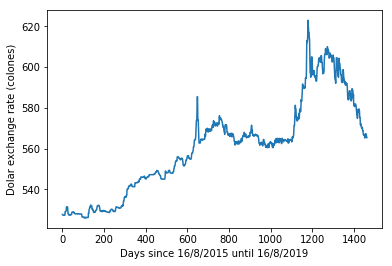

In [7]:
# create a proxy of the services provided in the WSDL
URL_WSDL = ("http://indicadoreseconomicos.bccr.fi.cr/\
IndicadoresEconomicos/WebServices/wsIndicadoresEconomicos.asmx?WSDL")
servicio = ServiceProxy(URL_WSDL)

# obtain today's date with the method from  https://www.saltycrane.com/blog/2008/06/how-to-get-current-date-and-time-in/
now = datetime.datetime.now()
fechaInicio = '%s/%s/%s' % (now.day, now.month, now.year-4)
fechaFinal = '%s/%s/%s' % (now.day, now.month, now.year)

# find the dollar exchange rate since a date in the past
dicc = servicio.ObtenerIndicadoresEconomicosXML(
	tcIndicador='317', # 317 dolares
	tcFechaInicio=fechaInicio,
	tcFechaFinal=fechaFinal,
	tcNombre = 'test',
	tnSubNiveles = 'N')

# extract the XML that comes embedded in the dictionary data structure
xml = dicc['ObtenerIndicadoresEconomicosXMLResult']
raiz = ET.fromstring(xml)

# store the tps://www.larepublica.net/noticia/el-libor-dejara-de-existir-en-el-2021

1. Linearobtained values in an array
z = []
for hijo in raiz:
	act = float(hijo[2].text)
	z.append(act)
    
# plot
N = len(z)
pylab.plot(z)
pylab.xlabel('Days since %s until %s' % (fechaInicio, fechaFinal))
pylab.ylabel('Dolar exchange rate (colones)')

## Random decimation of the original signal

To demonstrate the usefulness of the BLI we simulate the case in which samples are taken at random intervals. To do this, we iterate through the inputs of the original signal and keep each sample only if the random number generated is less than a defined $p$ value (do not confuse with the significance level on hypothesis testing).

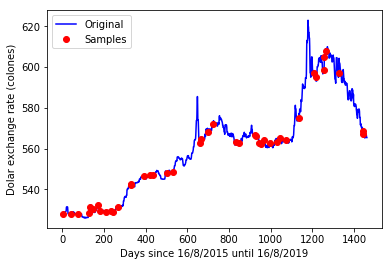

In [8]:
import random

x = numpy.arange(N)  # eje de las ordenadas
xm = []
zm = []
for dia in range(len(x)):
    if random.random()<0.03:
        xm.append(x[dia])
        zm.append(z[dia])
    
# graficamos el resultado
pylab.plot(x,z,'b-',xm,zm,'or') 
pylab.xlabel('Days since %s until %s' % (fechaInicio, fechaFinal))
pylab.ylabel('Dolar exchange rate (colones)')
legend(('Original','Samples'))

Here we see red dots that represent the new signal we are going to work on. A linear interpolation would join the available points with a straight line, but the obtained approximation would not be smooth. However, we proceed to build it for illustrative purposes.

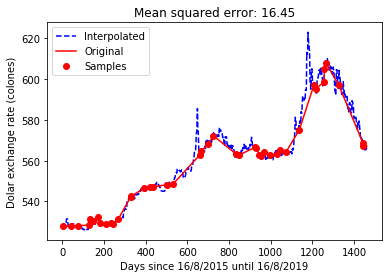

In [10]:
zm1 = numpy.interp(x, xm, zm, left=None, right=None, period=None)
pylab.plot(x,z,'b--',x,zm1,'r-',xm,zm,'or') 
pylab.xlabel('Days since %s until %s' % (fechaInicio, fechaFinal))
pylab.ylabel('Dolar exchange rate (colones)')
error = numpy.mean(numpy.power(numpy.array(z)-numpy.array(zm1),2))
pylab.title('Mean squared error: %.2f' % error)
legend(('Interpolated', 'Original','Samples'))

## Limited band interpolation

Now we use BLI to approximate the original signal using a smoother curve with greater robustness against missing data.

Optimal order: 5



Text(0.5,1,'Mean squared error: 904.98')

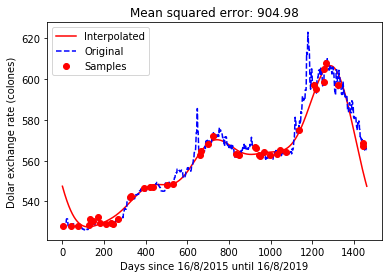

In [11]:
def BL_interp_1D(x, z, T, order, grid_step=0.01, win=True):
    """
    Band-limited interpolation of 1D functions (tomado de P.Prandoni y M.Vetterli)
    """
    # Create Fourier order vector
    k = np.expand_dims(arange(-order, order+1), 0)

    # construct the Fourier matrix
    F = exp(2j*pi*x*k/(T[1]-T[0]))

    # Least-square projection (alternatively linalg.lstsq can be used)
    C = dot(dot(linalg.inv(dot(F.T,F)), F.T), z)

    # create new evenly spaced grid
    xg = expand_dims(arange(T[0], T[1], grid_step), 1)

    # window the Fourier coefficients if requested
    if (win):
        C *= expand_dims(hanning(2*order+1), 1)

    zg = dot(exp(2j*pi*xg*k/(T[1]-T[0])), C)

    return zg, xg, C, k

'''
Let's apply the BL interpolation
'''
T = [0, N]
xmp = expand_dims(array(xm),1)
zmp = expand_dims(array(zm),1)

# calculte the BL interpolation and optimize
ordenes = range(5,10)
O = len(ordenes)
errores = [0.0]*O
for i in range(0,O):
    zp1, xp1, C1, k1 = BL_interp_1D(xmp, zmp, T, ordenes[i], win=False)
    errores[i] = numpy.mean(numpy.power(numpy.array(zm1)-numpy.real(zp1),2))

iOpt = argmin(errores)
print 'Optimal order: %i\n' % ordenes[iOpt]
zp1, xp1, C1, k1 = BL_interp_1D(xmp, zmp, T, ordenes[iOpt], win=False)
    
# plot the result
plot(xp1, numpy.real(zp1), 'r', x, z, 'b--',xm,zm,'or')
pylab.xlabel('Days since %s until %s' % (fechaInicio, fechaFinal))
pylab.ylabel('Dolar exchange rate (colones)')
legend(('Interpolated', 'Original','Samples'))
pylab.title('Mean squared error: %.2f' % errores[iOpt])

Although it is noted that the BLI has a higher MSE compared to linear interpolation, it offers a smoother and cheaper interpolation, because it is only necessary to save the vector of coefficients (that usually takes 5 to 15 coefficient) to store the whole signal approximation. Take into account that if you want to store higher frequencies more coefficients are needed.

## Number of coefficients to store

If the low frequencies of the signal are not important, but only the general trend, the BLI method can be used to "compress" the data and save disk space. Recalling that $N$ is the number of samples of the original signal and $M$ the number of coefficients used, the "compression rate" $c$ is calculated as follows:

$$c = \frac{N-M}{N}.$$

**Note:** the imaginary component of analyzed signal is zero, therefore the coefficient vector is even, and this allows us to discard half of the coefficients.

Number of samples: 1462
Number of coefficients needed to reproduce the signal: 5
Compression achieved: 99%


Text(0.5,1,'Logarithmic magnitude of the Fourier coefficients')

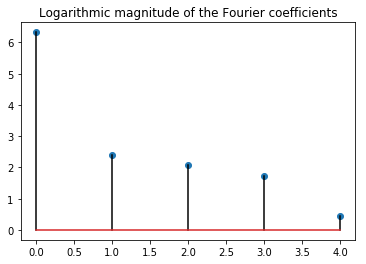

In [12]:
M = ordenes[iOpt]
c = float(N-M)/N
print 'Number of samples: %i' % N
print 'Number of coefficients needed to reproduce the signal: %i' % M
print 'Compression achieved: %i%%' % (c*100)

stem(k1.T[M:-1], np.log(np.abs(C1[M:-1])), 'k')
title('Logarithmic magnitude of the Fourier coefficients')

**Note:** Although the BLI is a good interpolation method, it was not designed to perform extrapolation, that is, to predict the future, for this, probabilistic and computer learning methods are used.

## References:

1. Banco Central de Costa Rica. **Catálogo de indicadores económicos disponibles a consultar**. URL: http://www.bccr.fi.cr/indicadores_economicos_/ServicioWeb.html. Last consulted on: 04/11/15

1. LCAV, Ecolé Polytechnique Federale de Lausanne. **Safecast : Band-limited interpolation of radiation measurements in Fukushima** URL: https://nbviewer.jupyter.org/github/LCAV/SignalsOfTheDay/blob/master/Safecast/Safecast.ipynb

1. P. Prandoni, M. Vertterli. **Signal processing for communications.** EPFL press 2008.

1. Wikipedia contributors. (2019, August 1). Libor scandal. In Wikipedia, The Free Encyclopedia. Retrieved 23:50, August 15, 2019, from https://en.wikipedia.org/w/index.php?title=Libor_scandal&oldid=908807968.

1. Miguel Elizondo. El LIBOR dejará de existir en el 2021. La República.net, Impacto legal. Monday, July 31-th, 2017. URL: https://www.larepublica.net/noticia/el-libor-dejara-de-existir-en-el-2021

1. Linear interpolation example. International Swaps and Derivatives Association. URL: https://www.isda.org/a/7KiDE/linear-interpolation-example-1-10.pdf

1. Penn engineering. Least Squares, Pseudo-Inverses, PCA & SVD. URL: http://www.cis.upenn.edu/~cis610/cis61009sl10.pdf

## Notes

1. In these cases, we talk about "innovation rate" (FIR), rather than sampling frequency.
2. It can be proven that the [least squares method] (https://es.wikipedia.org/wiki/M%C3%ADnimos_cuadrados) works using the standard approximation theorem.
3. An excellent resource on how to use the services of the BCCR can also be found at [Tico] (https://tecnitico.wordpress.com/2010/11/11/webservice-del-banco-central-de-costa-rica- y-ruby /).
4. The images were taken from the sites:
https://i.dailymail.co.uk/i/pix/2012/07/12/article-2172377-140736A7000005DC-647_634x422.jpg and https://c8.alamy.com/comp/CTX670/libor-scandal-headlines-the-financial-times-newspaper-london-august-CTX670.jpg


---
<a rel="license" href="http://creativecommons.org/licenses/by-nd/4.0/"><img alt="licencia Creative Commons" style="border-width:0" src="img/80x15_by-nd.png" /></a><p style="text-align: center;"> This work is under a <a rel="license" href="http://creativecommons.org/licenses/by-nd/4.0/">Creative Commons Atribución 4.0 Internacional license</a>. The website <a href="https://juanfonsecasolis.github.io/">juanfonsecasolis.github.io</a> It is a Costa Rican blog dedicated to independent research on issues related to digital signal processing. To reuse this article and cite the source you can use Bibtex:</p>
```
@online{Fonseca2018,
  author = {Juan M. Fonseca-Solís},
  title = { Limited band interpolation for daily reference rates},
  year = 2015,
  url = {https://juanfonsecasolis.github.io/blog/JFonseca.interpolacionBL.html},
  urldate = {}
}
```

<!-- DISQUIS -->

<div id="disqus_thread"></div>
<script>

/**
*  RECOMMENDED CONFIGURATION VARIABLES: EDIT AND UNCOMMENT THE SECTION BELOW TO INSERT DYNAMIC VALUES FROM YOUR PLATFORM OR CMS.
*  LEARN WHY DEFINING THESE VARIABLES IS IMPORTANT: https://disqus.com/admin/universalcode/#configuration-variables
*/
var disqus_config = function () {
this.page.url = 'https://juanfonsecasolis.github.io/blog/JFonseca.interpolacionBL.html';  // Replace PAGE_URL with your page's canonical URL variable
this.page.identifier = 1; // Replace PAGE_IDENTIFIER with your page's unique identifier variable
};

(function() { // DON'T EDIT BELOW THIS LINE
var d = document, s = d.createElement('script');
s.src = 'https://https-juanfonsecasolis-github-io.disqus.com/embed.js';
s.setAttribute('data-timestamp', +new Date());
(d.head || d.body).appendChild(s);
})();
</script>
<noscript>Please enable JavaScript to view the <a href="https://disqus.com/?ref_noscript">comments powered by Disqus.</a></noscript>
<script id="dsq-count-scr" src="//https-juanfonsecasolis-github-io.disqus.com/count.js" async></script>